# Boosting Model for CT adjustment

## Imports & Utils

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [1]:
from gradient_boosting import *
from utils import *

## Load Data

For this analysis, you'll need 2 files:
1. csv file containing all the property listed/sold in a given market area (e.g. Denver)
2. csv file containing the details about the census tract level features in the given market area



As of Dec 2020, the most recent version of the data is currently stored in our shared google drive (url to the files is in the below code).

If you want to just load the data from the google drive, you can execute the following command to load the data (simply paste the url for census tract features csv file to `census_tract_url` and the property listing csv file to `listing_url` in the below command).

In [3]:
# census_tract_url='https://drive.google.com/file/d/1K9DgN4kznwJOimZD6i3iUfVn2icfdFBX/view?usp=sharing'
# df = load_data(census_tract_url)
# listing_url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
# listings = load_data(listing_url)

In [5]:
market_area = 'denver'
data_dir = 'index-team-data'
data_path = f'../{data_dir}/{market_area}'

In [6]:
df = pd.read_csv(f'{data_path}/census_tract_data.csv')
listings = pd.read_csv(f'{data_path}/listing_dates_with_ct.csv')

In [4]:
display(df.head())
listings.head()

,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,...,>1M,married,divorced/separated/widowed,never_married,percent_mortgage,median_mortgage_value,vacancy_rate,built 2014 or later,built 2010-2013,built 2000-2009
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,...,0.056075,33.7,22.8,43.5,0.803738,173000.0,0.057437,0.000000,0.000000,0.130339
1,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,...,0.000000,34.1,16.1,49.8,0.724409,256600.0,0.063513,0.000000,0.000000,0.015554
2,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,...,0.015576,38.7,14.9,46.5,0.860395,174000.0,0.058824,0.002966,0.014829,0.007909
3,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,...,0.000000,43.6,18.4,37.9,0.757377,223400.0,0.027945,0.003836,0.000000,0.003836
4,8001008100,2203.0,10.072085,100.0,820.952275,71.0,51.0,1.0,19.0,29.0,...,0.000000,30.8,17.1,52.1,0.269231,34400.0,0.136087,0.063183,0.290401,0.507898


,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09


## Preprocess data 
- Parsing date time object 
- Merging CT-level features and listing datasets together
- Calculate listing and sales ratio
- Drop census tract with not enough data (less than 10 monthly data for listings/sales rate)
- Drop redundant columns

In [4]:
df_merged = preprocess_data(df, listings)
print(df_merged.shape)
print(df_merged.ct_key.nunique())
print(len(df_merged))
df_merged.head()

(41367, 121)
746
41367


,ct_key,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,densely_urban_score,urban_score,suburban_score,rural_score,remote_score,...,built 2000-2009,month,ct_count_listings,ct_count_sales,sales_per_households,listings_per_households,ct_listings_per_households,ct_sales_per_households,relative_listings_toBaseline,relative_sales_toBaseline
0,8001007801,1316.0,6.024884,100.0,15066.473217,7.0,10.0,33.0,83.0,93.0,...,0.130339,2016-03-01,3.0,3.0,0.003846,0.009463,0.002344,0.002344,0.247662,0.609404
54,8001007802,1239.0,9.187587,100.0,15270.696288,7.0,10.0,33.0,83.0,93.0,...,0.015554,2016-03-01,4.0,1.0,0.003846,0.009463,0.002768,0.000692,0.292510,0.179939
104,8001007900,1482.0,10.041348,100.0,8644.378631,14.0,6.0,26.0,76.0,86.0,...,0.007909,2016-03-01,15.0,7.0,0.003846,0.009463,0.007878,0.003676,0.832478,0.955928
160,8001008000,1499.0,7.532211,100.0,7448.779496,17.0,3.0,23.0,73.0,83.0,...,0.003836,2016-03-01,12.0,7.0,0.003846,0.009463,0.006764,0.003946,0.714786,1.025979
218,8001008200,2190.0,9.419278,100.0,3255.950515,41.0,21.0,0.0,49.0,59.0,...,0.008508,2016-03-01,8.0,5.0,0.003846,0.009463,0.005236,0.003272,0.553242,0.850826


## Predict Ratio of of Listing Rates

### Build Model

In [5]:
# build the objects - XGB and LGBM for listings rate prediction
LGBM_listing = LGBM_model(df_merged, target='relative_listings_toBaseline', )
XGB_listing = XGB_model(df_merged, target='relative_listings_toBaseline')

# hyperparameter tuning
LGBM_listing.find_bestparams()
XGB_listing.find_bestparams()
# LGBM_listing.hyperparameter = {'learning_rate': 0.00872299852436799, 'n_estimators': 1100, 'num_leaves': 362, 'reg_alpha': 6, 'reg_lambda': 0.8060800070826718}
# XGB_listing.hyperparameter = {'learning_rate': 0.009954737901026542, 'max_depth': 10.0, 'n_estimators': 1300.0, 'reg_alpha': 5.0, 'reg_lambda': 0.15592172326978576}

# print the best hyperparameter chosen
print(LGBM_listing.hyperparameter)
print(XGB_listing.hyperparameter)

{'learning_rate': 0.00872299852436799, 'n_estimators': 1100, 'num_leaves': 362, 'reg_alpha': 6, 'reg_lambda': 0.8060800070826718}
{'learning_rate': 0.009954737901026542, 'max_depth': 10.0, 'n_estimators': 1300.0, 'reg_alpha': 5.0, 'reg_lambda': 0.15592172326978576}


LGBMRegressor(colsample_bytree=0.62, learning_rate=0.00872299852436799,
              min_child_weight=1.12, n_estimators=1100, num_leaves=362,
              objective='regression', reg_alpha=6,
              reg_lambda=0.8060800070826718)

MAE training: 0.34918368489598034
MAE testing: 0.352927829626315


XGBRegressor(base_score=0.88085259234882, booster=None, colsample_bylevel=0.7,
             colsample_bynode=None, colsample_bytree=0.62, eval_metric='mae',
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.009954737901026542,
             max_delta_step=None, max_depth=10, min_child_weight=1.12,
             missing=nan, monotone_constraints=None, n_estimators=1300,
             n_jobs=None, num_parallel_tree=None, random_state=None,
             reg_alpha=5, reg_lambda=0.15592172326978576, scale_pos_weight=None,
             subsample=None, tree_method=None, validate_parameters=None,
             verbosity=None)

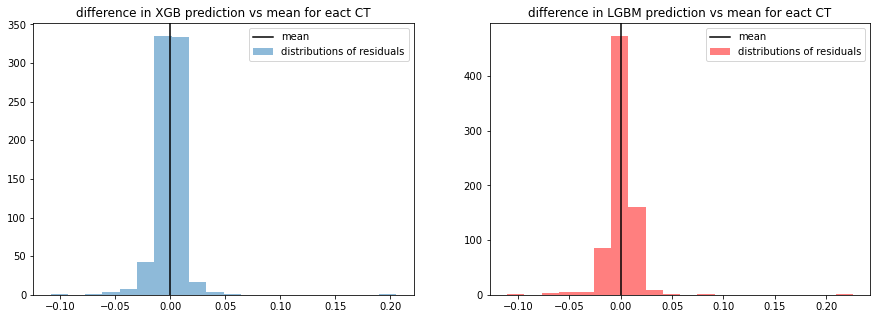

In [6]:
# build the final model with the chosen hyperparameter
LGBM_listing.build_model()
print("\n")
XGB_listing.build_model()
print("\n")

fig, ax=plt.subplots(1,2,figsize=(15,5))
resid_XGB_listing = XGB_listing.evaluate_model(show_plot=False, ax=ax[0])
resid_LGBM_listing= LGBM_listing.evaluate_model(show_plot=False, ax=ax[1])


### Model Evaluation

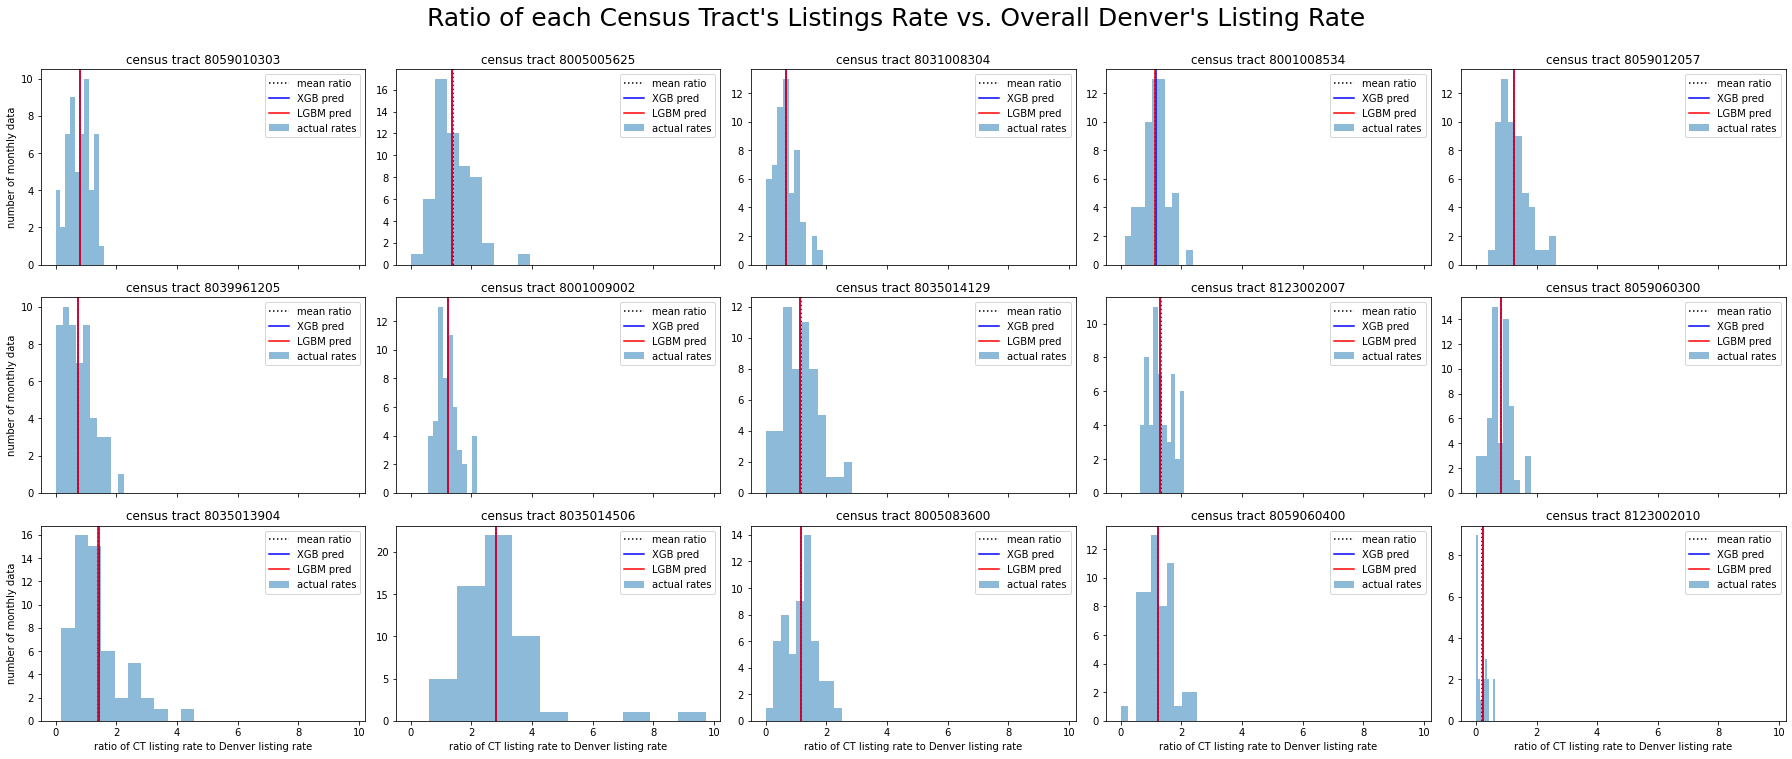

In [9]:
# get 15 randomly sampled census tract
np.random.seed(100)
samples_ct = np.random.choice(df_merged.ct_key.unique(), 15, replace=False)

# plot the prediction for each census tract
fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
XGB_listing.plot_pred_CT( samples_ct, ax, plot_distribution=True)
LGBM_listing.plot_pred_CT(samples_ct, ax, plot_distribution=False)

# add axis label, axis title, figure title.
fig.suptitle("Ratio of each Census Tract's Listings Rate vs. Overall Denver's Listing Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(samples_ct):
    ax[idx//5, idx%5].set_title(f"census tract {ct}")
    if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT listing rate to Denver listing rate")
    if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")
plt.tight_layout()

### Visualization

#### Feature Importance

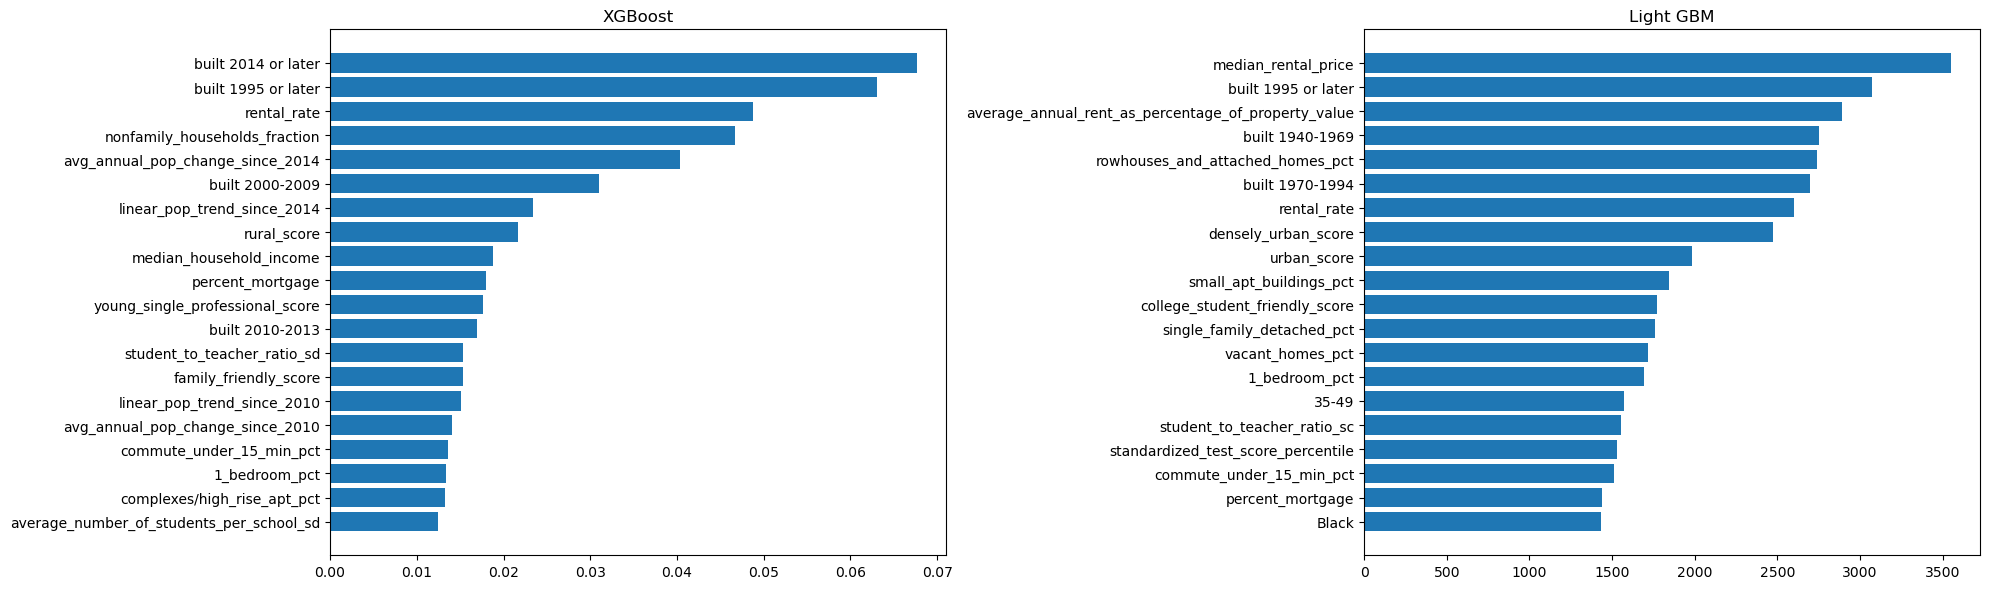

In [8]:
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
XGB_listing.plot_feature_importance(ax[0])
LGBM_listing.plot_feature_importance(ax[1])
            
plt.tight_layout()

#### Feature Contribution 

Using the idea of XGBoost explainer package from R to build our own visualization:
- every bar indicates how each feature contributes to the final prediction value
- green means positive contribution, red means negative contribution
- final prediction is given by the dashed horizontal line

Note: Please put in the index number of which census tract do you want to explore more with the following feature contribution plot. You can retrieve the index by specifying the desired census tract number and executing the command below:

In [8]:
index_ctkey_mapping = XGB_listing.df_test_pred.reset_index()['ct_key']
census_tracts_toExplore = [8035013901, 8001008603]

idx_census_tracts_toExplore = []
for ct in census_tracts_toExplore:
    idx = index_ctkey_mapping[index_ctkey_mapping==ct].index.values[0]
    idx_census_tracts_toExplore.append(idx)
    print(f"index number for census tract {ct} : {idx}")


index number for census tract 8035013901 : 10
index number for census tract 8001008603 : 20


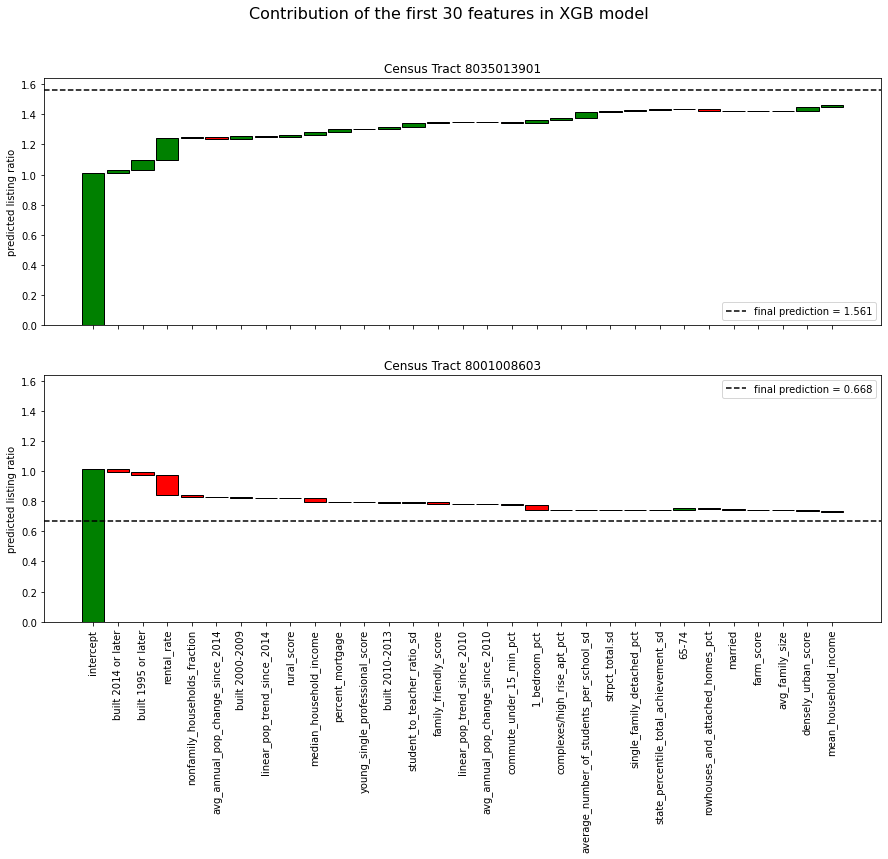

In [11]:
XGB_listing.plot_feature_contribution(sample_idx=idx_census_tracts_toExplore, ylabel="predicted listing ratio" )

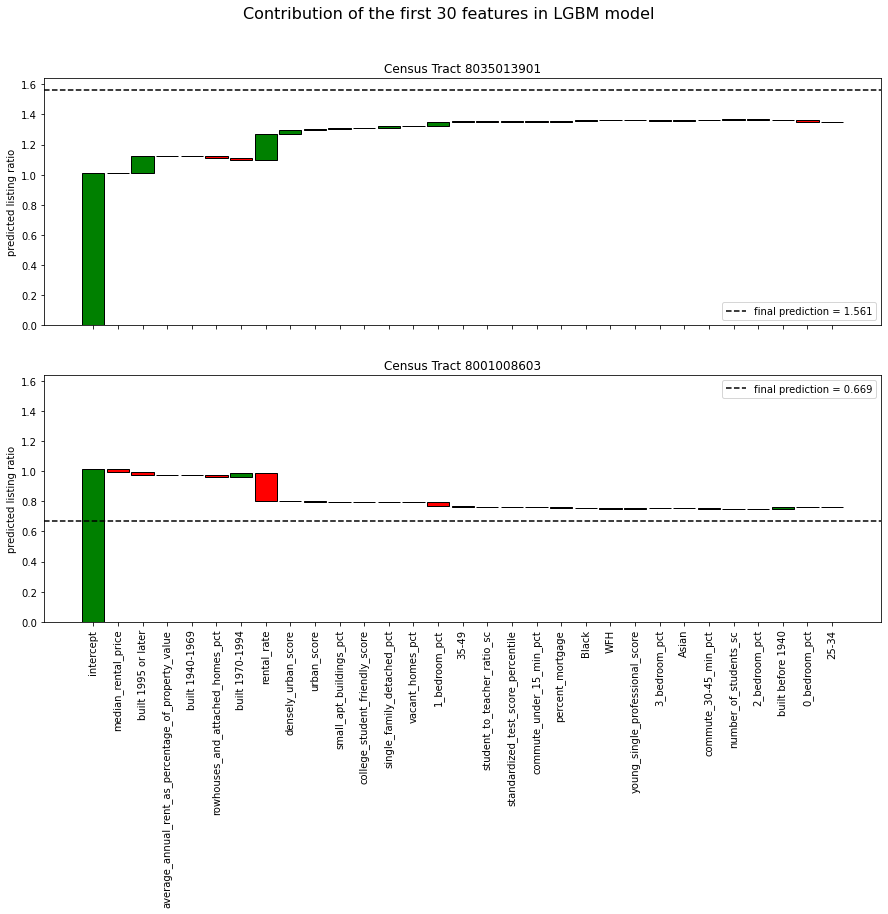

In [10]:
LGBM_listing.plot_feature_contribution(sample_idx=idx_census_tracts_toExplore, ylabel="predicted listing ratio" )

## Predict Ratio of Home Sales Rate

### Build Model

In [11]:
# build the objects - XGB and LGBM for sales rate prediction
LGBM_sales = LGBM_model(df_merged, target='relative_sales_toBaseline')
XGB_sales = XGB_model(df_merged, target='relative_sales_toBaseline')

# hyperparameter tuning
# LGBM_sales.find_bestparams()
# XGB_sales.find_bestparams()

# print the best hyperparameter chosen
print(LGBM_sales.hyperparameter)
print(XGB_sales.hyperparameter)


100%|██████████| 50/50 [49:20<00:00, 59.20s/trial, best loss: 0.3437334269476117]   
{'learning_rate': 0.006221407809557736, 'n_estimators': 1600.0, 'num_leaves': 170.0, 'reg_alpha': 17.0, 'reg_lambda': 0.5351018416899286}
{'learning_rate': 0.009288571560656515, 'max_depth': 10.0, 'n_estimators': 500.0, 'reg_alpha': 5.0, 'reg_lambda': 0.24921260446041163}


LGBMRegressor(colsample_bytree=0.62, learning_rate=0.006221407809557736,
              min_child_weight=1.12, n_estimators=1600, num_leaves=170,
              objective='regression', reg_alpha=17,
              reg_lambda=0.5351018416899286)

MAE training: 0.3457077880083994
MAE testing: 0.34563376822276076


XGBRegressor(base_score=0.9042659969901782, booster=None, colsample_bylevel=0.7,
             colsample_bynode=None, colsample_bytree=0.62, eval_metric='mae',
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.009288571560656515,
             max_delta_step=None, max_depth=10, min_child_weight=1.12,
             missing=nan, monotone_constraints=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=None,
             reg_alpha=5, reg_lambda=0.24921260446041163, scale_pos_weight=None,
             subsample=None, tree_method=None, validate_parameters=None,
             verbosity=N

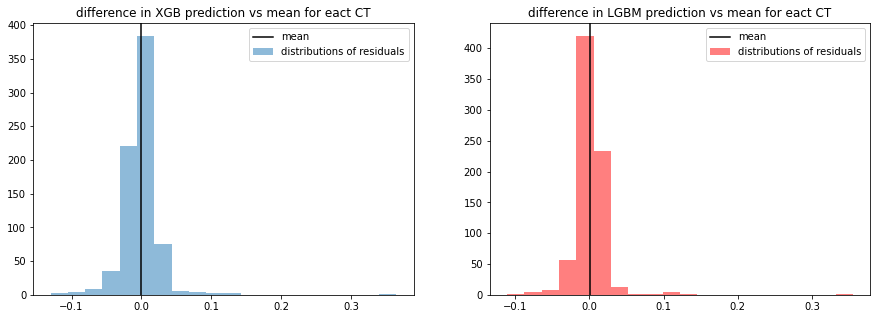

In [13]:
# build the final model with the chosen hyperparameter
LGBM_sales.build_model()
print("\n")
XGB_sales.build_model()
print("\n")

fig, ax=plt.subplots(1,2,figsize=(15,5))
resid_XGB_sales = XGB_sales.evaluate_model(show_plot=False, ax=ax[0])
resid_LGBM_sales= LGBM_sales.evaluate_model(show_plot=False, ax=ax[1])


### Model Evaluation

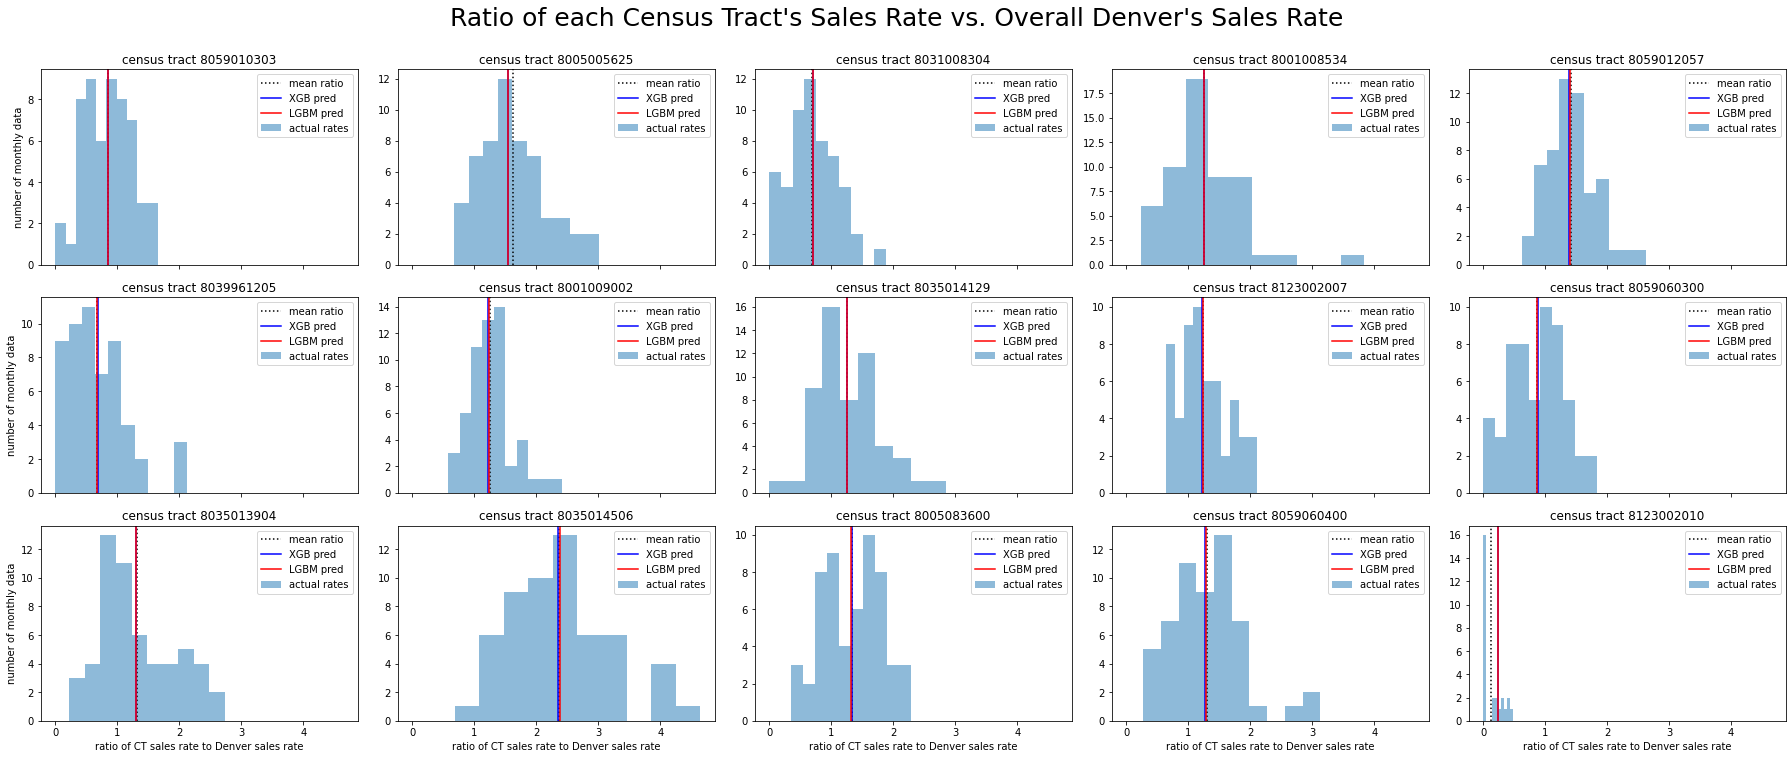

In [14]:
# get 15 randomly sampled census tract
np.random.seed(100)
samples_ct = np.random.choice(df_merged.ct_key.unique(), 15, replace=False)

# plot the prediction for each census tract
fig, ax = plt.subplots(3,5, sharex=True, figsize=(25,10))
XGB_sales.plot_pred_CT( samples_ct, ax, plot_distribution=True)
LGBM_sales.plot_pred_CT(samples_ct, ax, plot_distribution=False)

# add axis label, axis title, figure title.
fig.suptitle("Ratio of each Census Tract's Sales Rate vs. Overall Denver's Sales Rate", fontsize=25, y=1.05)
for idx, ct in enumerate(samples_ct):
    ax[idx//5, idx%5].set_title(f"census tract {ct}")
    if idx//5 == 2: ax[idx//5, idx%5].set_xlabel("ratio of CT sales rate to Denver sales rate")
    if idx%5 == 0: ax[idx//5, idx%5].set_ylabel("number of monthly data")
plt.tight_layout()

### Visualization

### Feature Importance

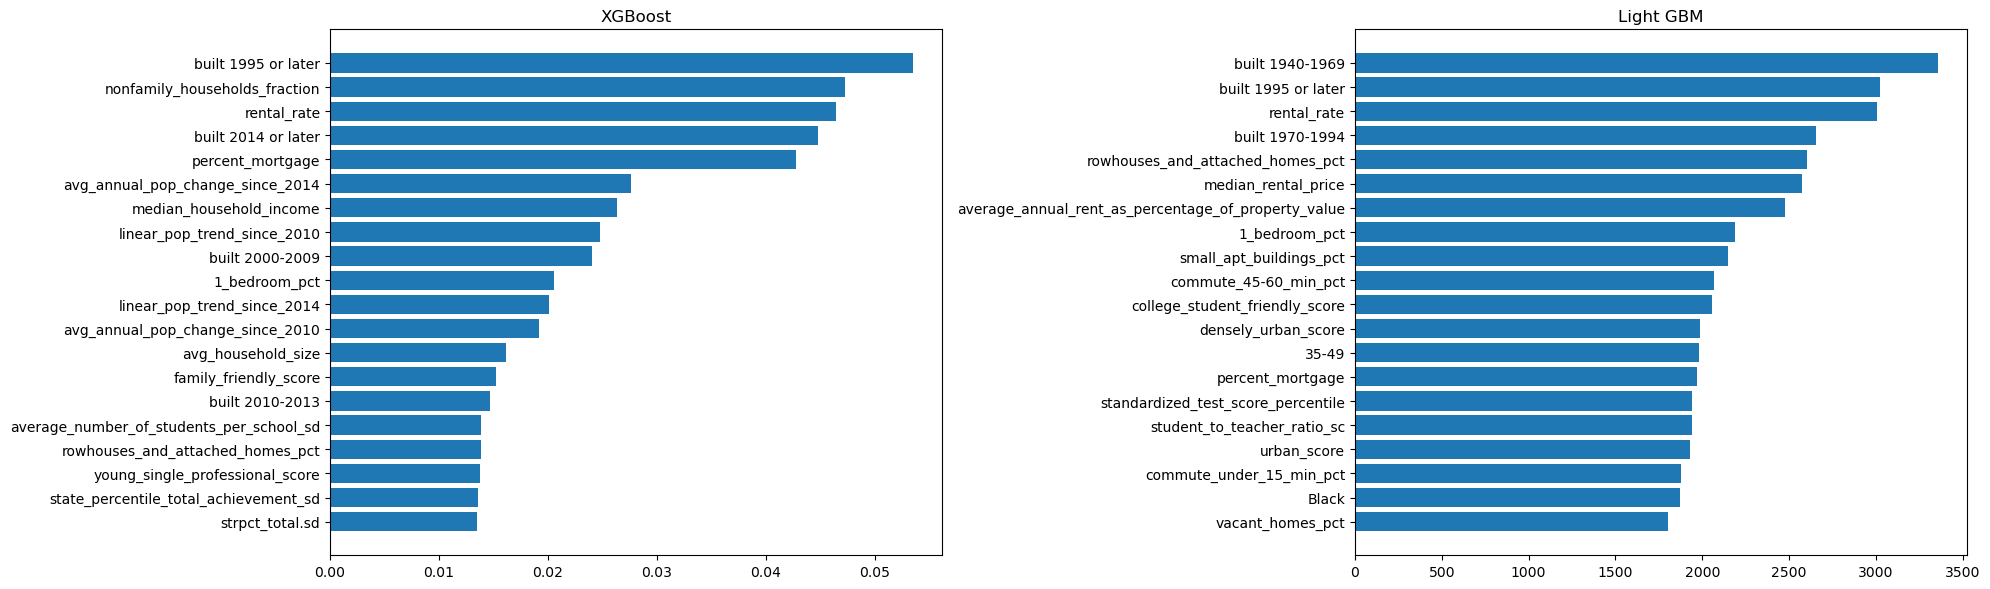

In [14]:
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
XGB_sales.plot_feature_importance(ax[0])
LGBM_sales.plot_feature_importance(ax[1])
            
plt.tight_layout()

### Feature Contribution

Note: Please put in the index number of which census tract do you want to explore more with the following feature contribution plot. You can retrieve the index by specifying the desired census tract number and executing the command below:

In [15]:
index_ctkey_mapping = XGB_sales.df_test_pred.reset_index()['ct_key']
census_tracts_toExplore = [8035013901, 8001008603]

idx_census_tracts_toExplore = []
for ct in census_tracts_toExplore:
    idx = index_ctkey_mapping[index_ctkey_mapping==ct].index.values[0]
    idx_census_tracts_toExplore.append(idx)
    print(f"index number for census tract {ct} : {idx}")


index number for census tract 8035013901 : 10
index number for census tract 8001008603 : 20


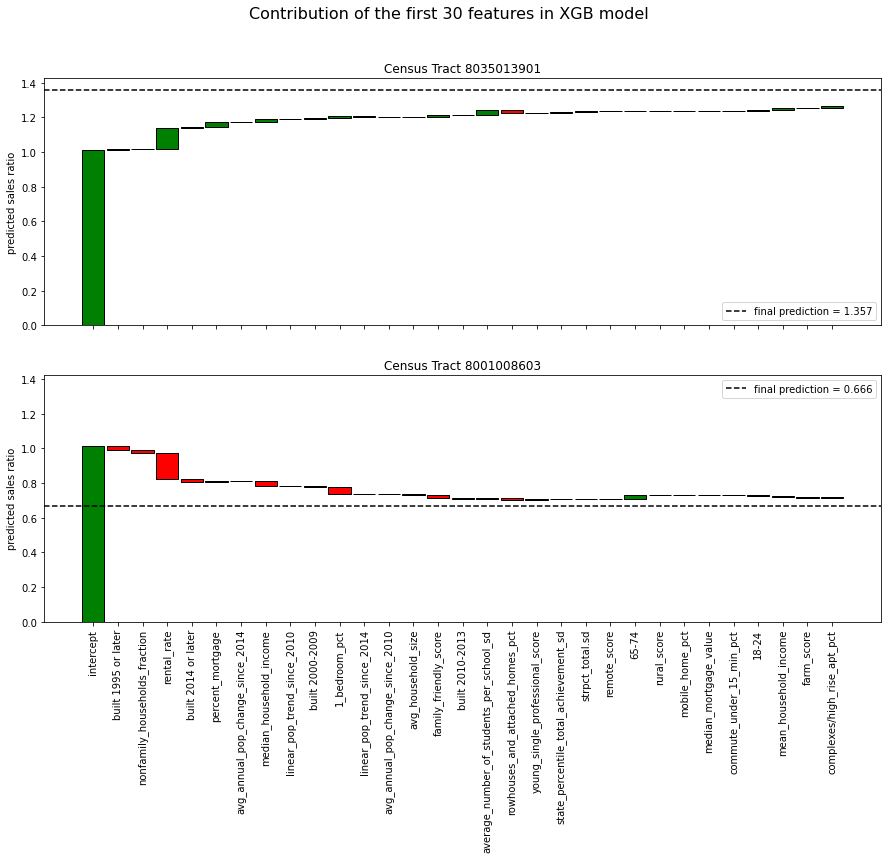

In [17]:
XGB_sales.plot_feature_contribution(sample_idx=idx_census_tracts_toExplore, ylabel="predicted sales ratio")

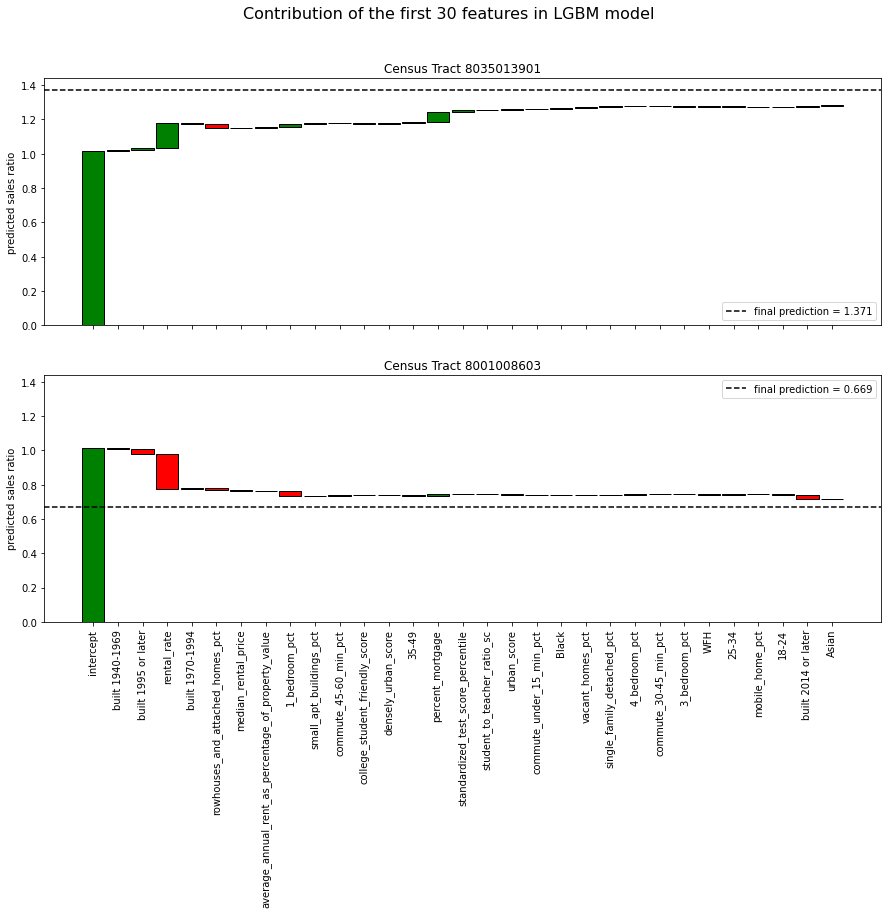

In [16]:
LGBM_sales.plot_feature_contribution(sample_idx=idx_census_tracts_toExplore, ylabel="predicted sales ratio")

In [21]:
df_merged[df_merged['ct_key'].isin([8035013901, 8001008603])].groupby(['ct_key']).mean()[['rental_rate', 'built 1940-1969', 'built 1995 or later']]


,rental_rate,built 1940-1969,built 1995 or later
ct_key,,,
8001008603,63.246753,33.577534,23.321123
8035013901,21.650668,5.777027,29.560811
